In this notebook, we demonstrate how to evaluate a trained event-SSM model on batches of unseen data on the three tasks:
 
1) Spiking Speech Commands
2) Spiking Heidelberg Digits
3) DVS128 Gesture 




# Setup

Install and load the important modules and configuration.

To install required packages, please do ``` pip3 install requirements.txt ``` <br>

Directories for loading datasets, model checkpoints and saving results are defined in the configuration file `system/local.yaml`.
Please set your directories accordingly.

The trained model checkpoints are [available for download](https://datashare.tu-dresden.de/s/g2dQCi792B8DqnC).

## Important Libraries
* [Hydra](https://hydra.cc/docs/intro/) - to manage configurations.
* [Flax](https://flax.readthedocs.io/en/latest/), Neural network package built on top of [Jax](https://jax.readthedocs.io/en/latest/) - for model development
* [Tonic](https://tonic.readthedocs.io/en/latest/) - for datasets

In [8]:
import os
from pathlib import Path
from functools import partial
from typing import Optional, TypeVar, Tuple, Union

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import tonic

import jax
import jax.numpy as jnp
from flax.training import checkpoints

from hydra import initialize, compose
from omegaconf import OmegaConf as om

from event_ssm.ssm import init_S5SSM
from event_ssm.seq_model import BatchClassificationModel

In [9]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Turn off GPU

# Task 1 - Spiking Heidelberg Digits

Spike-based version of Heidelberg digits dataset, consist of approximately 10k high-quality recordings of spoken digits ranging from zero to nine in English and German language.  In total 12 speakers were included, six of which were female and six male. 

Two speakers were heldout exclusively for the test set. The remainder of the test set was filled with samples (5 % of the trials) from speakers also present in the training set.



Ref : https://arxiv.org/pdf/1910.07407v3

### Step 1 : Load configuration

In [10]:
# Load configurations
with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name="base.yaml")

In [11]:
# See the model config:
print(om.to_yaml(cfg.model))

ssm_init:
  C_init: lecun_normal
  dt_min: 0.004
  dt_max: 0.1
  conj_sym: false
  clip_eigs: false
ssm:
  discretization: async
  d_model: 96
  d_ssm: 128
  ssm_block_size: 8
  num_stages: 2
  num_layers_per_stage: 3
  dropout: 0.23
  classification_mode: pool
  prenorm: true
  batchnorm: false
  bn_momentum: 0.95
  pooling_stride: 8
  pooling_mode: avgpool
  state_expansion_factor: 1



### Step 2 : Visualise data

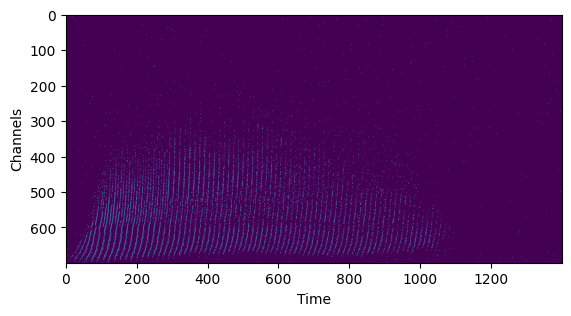

In [12]:
data = tonic.datasets.SHD(cfg.data_dir, train=False)
audio_events, label = data[0]
tonic.utils.plot_event_grid(audio_events)

### Step 3: Load single data sample for inference

In [13]:
DEFAULT_CACHE_DIR_ROOT = Path('./cache_dir/')
DataLoader = TypeVar('DataLoader')
InputType = [str, Optional[int], Optional[int]]
class Data:
    def __init__(
            self,
            n_classes: int,
            num_embeddings: int
            ):
        self.n_classes = n_classes
        self.num_embeddings = num_embeddings

In [14]:
def event_stream_collate_fn(batch, resolution, pad_unit, no_time_information=False):
    # x are inputs, y are targets, z are aux data
    x, y, *z = zip(*batch)
    assert len(z) == 0
    batch_size_one = len(x) == 1

    # set labels to numpy array
    y = np.stack(y)

    # integration time steps are the difference between two consequtive time stamps
    if no_time_information:
        timesteps = [np.ones_like(e['t'][:-1]) for e in x]
    else:
        timesteps = [np.diff(e['t']) for e in x]

    # NOTE: since timesteps are deltas, their length is L - 1, and we have to remove the last token in the following

    # process tokens for single input dim (e.g. audio)
    if len(resolution) == 1:
        tokens = [e['x'][:-1].astype(np.int32) for e in x]
    elif len(resolution) == 2:
        tokens = [(e['x'][:-1] * e['y'][:-1] + np.prod(resolution) * e['p'][:-1].astype(np.int32)).astype(np.int32) for e in x]
    else:
        raise ValueError('resolution must contain 1 or 2 elements')

    # get padding lengths
    lengths = np.array([len(e) for e in timesteps], dtype=np.int32)
    pad_length = (lengths.max() // pad_unit) * pad_unit + pad_unit

    # pad tokens with -1, which results in a zero vector with embedding look-ups
    tokens = np.stack(
        [np.pad(e, (0, pad_length - len(e)), mode='constant', constant_values=-1) for e in tokens])
    timesteps = np.stack(
        [np.pad(e, (0, pad_length - len(e)), mode='constant', constant_values=0) for e in timesteps])

    # timesteps are in micro seconds... transform to milliseconds
    timesteps = timesteps / 1000

    if batch_size_one:
        lengths = lengths[None, ...]

    return tokens, y, timesteps, lengths

In [15]:
def event_stream_dataloader(test_data,eval_batch_size,eval_collate_fn, rng, num_workers=0):
    def dataloader(dset, bsz, collate_fn, shuffle, drop_last):
        return torch.utils.data.DataLoader(
            dset,
            batch_size=bsz,
            drop_last=drop_last,
            collate_fn=collate_fn,
            shuffle=shuffle,
            generator=rng,
            num_workers=num_workers
        )
    test_loader = dataloader(test_data, eval_batch_size, eval_collate_fn, shuffle=True, drop_last=False)
    return test_loader

In [16]:
def create_events_shd_classification_dataset(
        cache_dir: Union[str, Path] = DEFAULT_CACHE_DIR_ROOT,
        per_device_eval_batch_size: int = 64,
        world_size: int = 1,
        num_workers: int = 0,
        seed: int = 42,
        pad_unit: int = 8192,
        no_time_information: bool = False,
        **kwargs
) -> Tuple[DataLoader, Data]:
    """
    creates a view of the spiking heidelberg digits dataset

    :param cache_dir:		                        (str):		where to store the dataset
    :param per_device_eval_batch_size:				(int):		Evaluation Batch size.
    :param seed:			                        (int):		Seed for shuffling data.
    """
    print("[*] Generating Spiking Heidelberg Digits Classification Dataset")

    if seed is not None:
        rng = torch.Generator()
        rng.manual_seed(seed)
    else:
        rng = None
    
    #target_transforms = OneHotLabels(num_classes=20)
    test_data = tonic.datasets.SHD(save_to=cache_dir, train=False)
    collate_fn = partial(event_stream_collate_fn, resolution=(700,), pad_unit=pad_unit, no_time_information=no_time_information)
    test_loader = event_stream_dataloader(
        test_data,
        eval_collate_fn=collate_fn,
        eval_batch_size=per_device_eval_batch_size * world_size,
        rng=rng, 
        num_workers=num_workers
    )
    data = Data(
        n_classes=20, num_embeddings=700)
    return test_loader, data

In [17]:
print("[*] Loading dataset...")
num_devices = jax.local_device_count()
test_loader, data = create_events_shd_classification_dataset(
        cache_dir=cfg.data_dir,
        seed=cfg.seed,
        world_size=num_devices,
        per_device_eval_batch_size = 1,
        pad_unit=cfg.training.pad_unit        
    )

[*] Loading dataset...
[*] Generating Spiking Heidelberg Digits Classification Dataset


In [18]:
# Load a sample
batch = next(iter(test_loader))
inputs, targets, timesteps, lengths = batch

### Step 4 : Load model

In [19]:
# Set the random seed manually for reproducibility.
init_key = jax.random.PRNGKey(cfg.seed)

In [20]:
# Model initialisation in flax
ssm_init_fn = init_S5SSM(**cfg.model.ssm_init)
model = BatchClassificationModel(
        ssm=ssm_init_fn,
        num_classes=data.n_classes,
        num_embeddings=data.num_embeddings,
        **cfg.model.ssm,
    )

In [21]:
# Visualise model
print(model.tabulate({"params": init_key},
        inputs, timesteps, lengths, False))

SSM: 96 -> 128 -> 96 (stride 8 with pooling mode avgpool)
SSM: 96 -> 128 -> 96
SSM: 96 -> 128 -> 96
SSM: 96 -> 128 -> 96 (stride 8 with pooling mode avgpool)
SSM: 96 -> 128 -> 96
SSM: 96 -> 128 -> 96

                        VmapClassificationModel Summary                         
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ Classificati… │ -             │ float32[20]  │               │
│               │               │ int32[16384]  │              │               │
│               │               │ -             │              │               │
│               │               │ float32[1638… │              │               │
│               │               │ - int32[1]    │              │               │
│               │               │ - False       │              │      

In [22]:
checkpoint_dir = os.path.abspath(os.path.join(cfg.checkpoint_dir, 'SHD'))
training_state = checkpoints.restore_checkpoint(checkpoint_dir, target=None)
params = training_state['params']
model_state = training_state['model_state']

/Users/jozseflurvig/GitHub Projects/event-ssm/checkpoints/SHD


### Step 5 - Model prediction

In [23]:
logits = model.apply({'params': params, **model_state}, inputs, timesteps, lengths, False)

SSM: 96 -> 128 -> 96 (stride 8 with pooling mode avgpool)
SSM: 96 -> 128 -> 96
SSM: 96 -> 128 -> 96
SSM: 96 -> 128 -> 96 (stride 8 with pooling mode avgpool)
SSM: 96 -> 128 -> 96
SSM: 96 -> 128 -> 96


In [24]:
print(f"Predicted label:{jnp.argmax(logits,axis=-1)}")
print(f"Actual label:{targets}")

Predicted label:[9]
Actual label:[9]


### Step 6 - Evaluate model on a batch

In [25]:
print("[*] Loading dataset...")
num_devices = jax.local_device_count()
test_loader, data = create_events_shd_classification_dataset(
        cache_dir=cfg.data_dir,
        seed=cfg.seed,
        world_size=num_devices,
        per_device_eval_batch_size = cfg.training.per_device_eval_batch_size,
        pad_unit=cfg.training.pad_unit,
        #no_time_information = cfg.training.no_time_information
        
    )

[*] Loading dataset...
[*] Generating Spiking Heidelberg Digits Classification Dataset


In [26]:
# Load a batch
batch = next(iter(test_loader))
inputs, targets, timesteps, lengths = batch
logits = model.apply({'params': params, **model_state},inputs, timesteps, lengths,False)

SSM: 96 -> 128 -> 96 (stride 8 with pooling mode avgpool)
SSM: 96 -> 128 -> 96
SSM: 96 -> 128 -> 96
SSM: 96 -> 128 -> 96 (stride 8 with pooling mode avgpool)
SSM: 96 -> 128 -> 96
SSM: 96 -> 128 -> 96


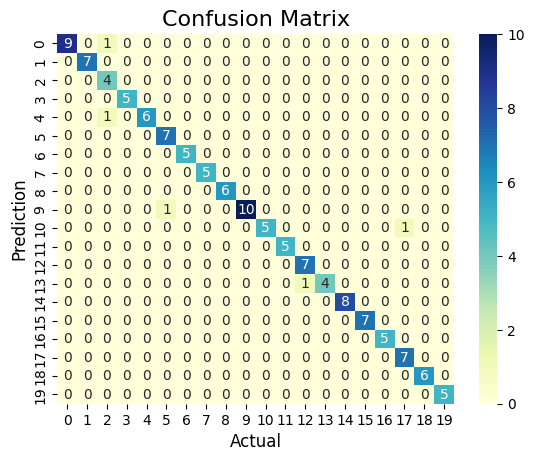

In [27]:
# Plot the confusion matrix
cm = confusion_matrix(jnp.argmax(logits,axis=1), targets)
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu')
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

In [28]:
print(f"Accuracy of the model: {(jnp.argmax(logits,axis=1)==targets).mean()}")

Accuracy of the model: 0.9609375


# Task 2 - Spiking Speech Commands 

The Spiking Speech Commands is based on the Speech Commands release by Google which consists of utterances recorded from a larger number of speakers under less controlled conditions. It contains 35 word categories from a larger number of speakers.

Ref : https://arxiv.org/pdf/1910.07407v3

### Step 1 : Load configuration

In [29]:
# Load configurations
with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name="base.yaml",overrides=["task=spiking-speech-commands"])

In [30]:
# See the model config:
print(om.to_yaml(cfg.model))

ssm_init:
  C_init: lecun_normal
  dt_min: 0.0015
  dt_max: 0.1
  conj_sym: true
  clip_eigs: false
ssm:
  discretization: async
  d_model: 96
  d_ssm: 128
  ssm_block_size: 16
  num_stages: 2
  num_layers_per_stage: 3
  dropout: 0.23
  classification_mode: pool
  prenorm: true
  batchnorm: true
  bn_momentum: 0.95
  pooling_stride: 8
  pooling_mode: avgpool
  state_expansion_factor: 2



### Step 2 : Visualise data

  0%|          | 0/323314930 [00:00<?, ?it/s]

Extracting ./data/SSC/ssc_test.h5.zip to ./data/SSC


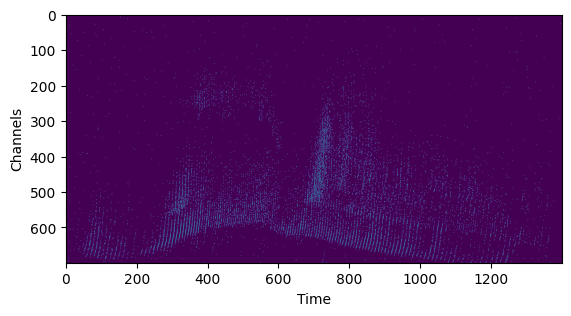

In [31]:
data = tonic.datasets.SSC(cfg.data_dir, split='test')
audio_events, label = data[0]
tonic.utils.plot_event_grid(audio_events)

### Step 3: Load single data sample for inference

In [32]:
def create_events_ssc_classification_dataset(
        cache_dir: Union[str, Path] = DEFAULT_CACHE_DIR_ROOT,
        per_device_eval_batch_size: int = 64,
        world_size: int = 1,
        num_workers: int = 0,
        seed: int = 42,
        pad_unit: int = 8192,
        no_time_information: bool = False,
        **kwargs
) -> Tuple[DataLoader, DataLoader, DataLoader, Data]:
    """
    creates a view of the spiking speech commands dataset

    :param cache_dir:		(str):		where to store the dataset
    :param bsz:				(int):		Batch size.
    :param seed:			(int)		Seed for shuffling data.
    """
    print("[*] Generating Spiking Speech Commands Classification Dataset")

    if seed is not None:
        rng = torch.Generator()
        rng.manual_seed(seed)
    else:
        rng = None

    test_data = tonic.datasets.SSC(save_to=cache_dir, split='test')
    collate_fn = partial(event_stream_collate_fn, resolution=(700,), pad_unit=pad_unit, no_time_information=no_time_information)
    test_loader = event_stream_dataloader(
        test_data,
        eval_collate_fn=collate_fn,
        eval_batch_size=per_device_eval_batch_size * world_size,
        rng=rng, 
        num_workers=num_workers,
    )

    data = Data(
        n_classes=35, num_embeddings=700
    )
    return test_loader, data


In [33]:
print("[*] Loading dataset...")
num_devices = jax.local_device_count()
test_loader, data = create_events_ssc_classification_dataset(
        cache_dir=cfg.data_dir,
        seed=cfg.seed,
        world_size=num_devices,
        per_device_eval_batch_size = 1,
        pad_unit=cfg.training.pad_unit        
    )

[*] Loading dataset...
[*] Generating Spiking Speech Commands Classification Dataset


In [34]:
# Load a sample
batch = next(iter(test_loader))
inputs, targets, timesteps, lengths = batch

### Step 4 : Load model

In [35]:
# Set the random seed manually for reproducibility.
init_key = jax.random.PRNGKey(cfg.seed)

In [36]:
ssm_init_fn = init_S5SSM(**cfg.model.ssm_init)
model = BatchClassificationModel(
        ssm=ssm_init_fn,
        num_classes=data.n_classes,
        num_embeddings=data.num_embeddings,
        **cfg.model.ssm,
    )

In [37]:
print(model.tabulate({"params": init_key},
        inputs, timesteps, lengths, False))

SSM: 96 -> 128 -> 96 (stride 8 with pooling mode avgpool)
SSM: 96 -> 128 -> 96
SSM: 96 -> 128 -> 96
SSM: 96 -> 256 -> 192 (stride 8 with pooling mode avgpool)
SSM: 192 -> 256 -> 192
SSM: 192 -> 256 -> 192

                        VmapClassificationModel Summary                         
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ path       ┃ module     ┃ inputs     ┃ outputs    ┃ batch_sta… ┃ params      ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│            │ Classific… │ -          │ float32[3… │            │             │
│            │            │ int32[819… │            │            │             │
│            │            │ -          │            │            │             │
│            │            │ float32[8… │            │            │             │
│            │            │ - int32[1] │            │            │             │
│            │            │ - False    │            │            

In [38]:
# load model parameters from checkpoint
checkpoint_dir = os.path.abspath(os.path.join(cfg.checkpoint_dir, 'SSC'))
training_state = checkpoints.restore_checkpoint(checkpoint_dir, target=None)
params = training_state['params']
model_state = training_state['model_state']

### Step 5 - Model prediction

In [39]:
logits = model.apply({'params': params, **model_state},inputs, timesteps, lengths,False)

SSM: 96 -> 128 -> 96 (stride 8 with pooling mode avgpool)
SSM: 96 -> 128 -> 96
SSM: 96 -> 128 -> 96
SSM: 96 -> 256 -> 192 (stride 8 with pooling mode avgpool)
SSM: 192 -> 256 -> 192
SSM: 192 -> 256 -> 192


In [40]:
print(f"Predicted label:{jnp.argmax(logits,axis=-1)}")
print(f"Actual label:{targets}")

Predicted label:[34]
Actual label:[34]


### Step 6 - Evaluate model on single batch

In [41]:
print("[*] Loading dataset...")
num_devices = jax.local_device_count()
test_loader, data = create_events_ssc_classification_dataset(
        cache_dir=cfg.data_dir,
        seed=cfg.seed,
        world_size=num_devices,
        per_device_eval_batch_size = cfg.training.per_device_eval_batch_size,
        pad_unit=cfg.training.pad_unit,
        #no_time_information = cfg.training.no_time_information
        
    )

[*] Loading dataset...
[*] Generating Spiking Speech Commands Classification Dataset


In [42]:
# Load a batch
batch = next(iter(test_loader))
inputs, targets, timesteps, lengths = batch

In [43]:
logits = model.apply({'params': params, **model_state},inputs, timesteps, lengths,False)

SSM: 96 -> 128 -> 96 (stride 8 with pooling mode avgpool)
SSM: 96 -> 128 -> 96
SSM: 96 -> 128 -> 96
SSM: 96 -> 256 -> 192 (stride 8 with pooling mode avgpool)
SSM: 192 -> 256 -> 192
SSM: 192 -> 256 -> 192


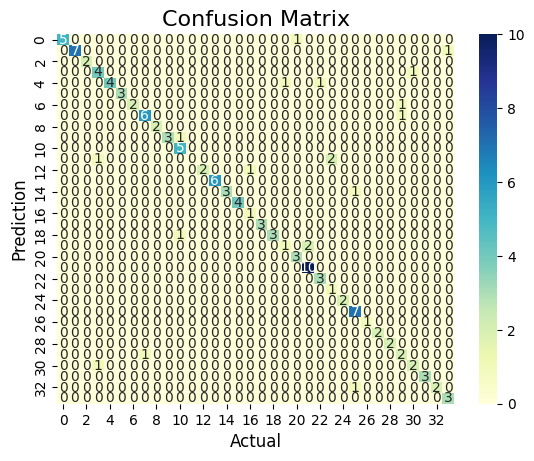

In [44]:
# Plot the confusion matrix
cm = confusion_matrix(jax.numpy.argmax(logits,axis=-1), targets)
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu')
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

In [45]:
print(f"Accuracy of the model: {(jnp.argmax(logits,axis=-1)==targets).mean()}")

Accuracy of the model: 0.8515625


# Task 3 - DVS Gesture 

## Task Description

It is the first gesture recognition system implemented end-to-end on event-based hardware. The dataset comprises of 11 hand gesture categories from 29 subjects under 3 illumination conditions.

Ref : https://ieeexplore.ieee.org/document/8100264

### Excercise

Similar to SHD and SSC, implement inference steps for DVS Gesture data.

### Step 1 : Load configuration

In [46]:
# Load configurations
with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name="base.yaml",overrides=["task=dvs-gesture"])

In [47]:
# model config:
print(om.to_yaml(cfg.model))

ssm_init:
  C_init: lecun_normal
  dt_min: 0.001
  dt_max: 0.1
  conj_sym: false
  clip_eigs: true
ssm:
  discretization: async
  d_model: 128
  d_ssm: 128
  ssm_block_size: 16
  num_stages: 2
  num_layers_per_stage: 3
  dropout: 0.25
  classification_mode: timepool
  prenorm: true
  batchnorm: false
  bn_momentum: 0.95
  pooling_stride: 16
  pooling_mode: timepool
  state_expansion_factor: 2



### Step 2 : Visualise Data

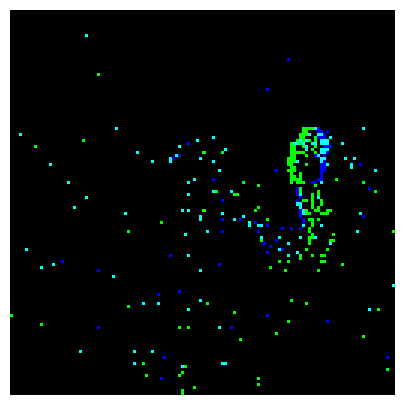

In [48]:
from IPython.display import HTML
import warnings

warnings.filterwarnings("ignore")

#warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

data = tonic.datasets.DVSGesture(cfg.data_dir, train=False)
events, label = data[0]

transform = tonic.transforms.Compose(
    [
        tonic.transforms.TimeJitter(std=100, clip_negative=False),
        tonic.transforms.ToFrame(
        sensor_size=data.sensor_size,
        time_window=10000,
        ),
    ]
)

frames = transform(events)
HTML(tonic.utils.plot_animation((frames* 255).astype(np.uint8)).to_html5_video())

### Step 3: Load single inference sample

In [49]:
from event_ssm.transform import Identity

In [50]:
def create_events_dvs_gesture_classification_dataset(
        cache_dir: Union[str, Path] = DEFAULT_CACHE_DIR_ROOT,
        per_device_eval_batch_size: int = 64,
        world_size: int = 1,
        num_workers: int = 0,
        seed: int = 42,
        pad_unit: int = 2 ** 19,
        downsampling: int=1,
        **kwargs
) -> Tuple[DataLoader, Data]:
    """
    creates a view of the DVS Gesture dataset

    :param cache_dir:		(str):		where to store the dataset
    :param bsz:				(int):		Batch size.
    :param seed:			(int)		Seed for shuffling data.
    """
    print("[*] Generating DVS Gesture Classification Dataset")

    if seed is not None:
        rng = torch.Generator()
        rng.manual_seed(seed)
    else:
        rng = None

    orig_sensor_size = (128, 128, 2)
    new_sensor_size = (128 // downsampling, 128 // downsampling, 2)
    test_transforms = tonic.transforms.Compose([
        tonic.transforms.Downsample(sensor_size=orig_sensor_size, target_size=new_sensor_size[:2]) if downsampling > 1 else Identity(),
    ])

    TestData = partial(tonic.datasets.DVSGesture, save_to=cache_dir, train=False)
    test_data = TestData(transform=test_transforms)

    # define collate function
    eval_collate_fn = partial(
            event_stream_collate_fn,
            resolution=new_sensor_size[:2],
            pad_unit=pad_unit,
        )
    test_loader = event_stream_dataloader(
        test_data,
        eval_collate_fn=eval_collate_fn,
        eval_batch_size=per_device_eval_batch_size * world_size,
        rng=rng, 
        num_workers=num_workers
        )

    data = Data(
        n_classes=11, num_embeddings=np.prod(new_sensor_size)
    )
    return test_loader, data

In [51]:
num_devices = jax.local_device_count()
    # Create dataset...
test_loader, data = create_events_dvs_gesture_classification_dataset(
        cache_dir=cfg.data_dir,
        seed=cfg.seed,
        world_size=num_devices,
        per_device_eval_batch_size = 1,
        pad_unit=cfg.training.pad_unit,        
    )

[*] Generating DVS Gesture Classification Dataset


In [52]:
# Load a sample
batch = next(iter(test_loader))
inputs, targets, timesteps, lengths = batch

### Step 4 : Load model

In [53]:
# Set the random key for the task
init_key = jax.random.PRNGKey(cfg.seed)

In [54]:
print("[*] Creating model...")
ssm_init_fn = init_S5SSM(**cfg.model.ssm_init)
model = BatchClassificationModel(
        ssm=ssm_init_fn,
        num_classes=data.n_classes,
        num_embeddings=data.num_embeddings,
        **cfg.model.ssm,
    )

[*] Creating model...


In [55]:
# visualise model
print(model.tabulate({"params": init_key},
        inputs, timesteps, lengths, False))

SSM: 128 -> 128 -> 128 (stride 16 with pooling mode timepool)
SSM: 128 -> 128 -> 128
SSM: 128 -> 128 -> 128
SSM: 128 -> 256 -> 256 (stride 16 with pooling mode timepool)
SSM: 256 -> 256 -> 256
SSM: 256 -> 256 -> 256

                        VmapClassificationModel Summary                         
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs       ┃ params       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│               │ Classificati… │ -             │ float32[11]   │              │
│               │               │ int32[524288] │               │              │
│               │               │ -             │               │              │
│               │               │ float32[5242… │               │              │
│               │               │ - int32[1]    │               │              │
│               │               │ - False       │     

In [56]:
# load model parameters from checkpoint
checkpoint_dir = os.path.abspath(os.path.join(cfg.checkpoint_dir, 'DVS'))
training_state = checkpoints.restore_checkpoint(checkpoint_dir, target=None)
params = training_state['params']
model_state = training_state['model_state']

### Step 5 - Model prediction

In [57]:
logits = model.apply({'params': params, **model_state}, inputs, timesteps, lengths, False)

SSM: 128 -> 128 -> 128 (stride 16 with pooling mode timepool)
SSM: 128 -> 128 -> 128
SSM: 128 -> 128 -> 128
SSM: 128 -> 256 -> 256 (stride 16 with pooling mode timepool)
SSM: 256 -> 256 -> 256
SSM: 256 -> 256 -> 256


In [58]:
print(f"Predicted label:{jnp.argmax(logits,axis=-1)}")
print(f"Actual label:{targets}")

Predicted label:[5]
Actual label:[5]


### Step 6 - Evaluate model on single batch

In [59]:
num_devices = jax.local_device_count()
    # Create dataset...
test_loader, data = create_events_dvs_gesture_classification_dataset(
        cache_dir=cfg.data_dir,
        seed=cfg.seed,
        world_size=num_devices,
        per_device_eval_batch_size = cfg.training.per_device_eval_batch_size,
        pad_unit=cfg.training.pad_unit,
        #no_time_information = cfg.training.no_time_information
    )

[*] Generating DVS Gesture Classification Dataset


In [60]:
# Load a batch
batch = next(iter(test_loader))
inputs, targets, timesteps, lengths = batch

In [61]:
logits = model.apply({'params': params, **model_state}, inputs, timesteps, lengths, False)

SSM: 128 -> 128 -> 128 (stride 16 with pooling mode timepool)
SSM: 128 -> 128 -> 128
SSM: 128 -> 128 -> 128
SSM: 128 -> 256 -> 256 (stride 16 with pooling mode timepool)
SSM: 256 -> 256 -> 256
SSM: 256 -> 256 -> 256


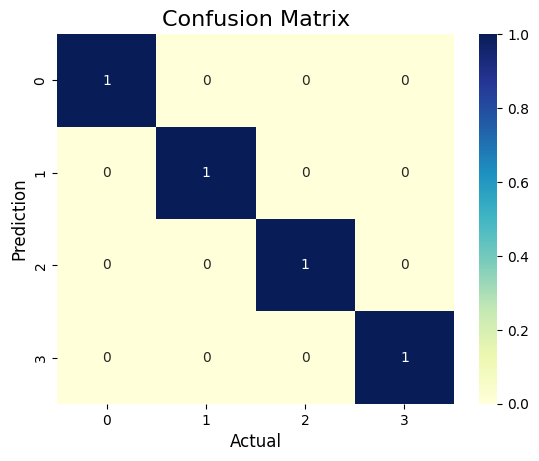

In [62]:
# Plot the confusion matrix
cm = confusion_matrix(jax.numpy.argmax(logits, axis=-1), targets)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.ylabel('Prediction', fontsize=12)
plt.xlabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [63]:
print(f"Accuracy of the model: {(jnp.argmax(logits, axis=-1) == targets).mean()}")

Accuracy of the model: 1.0
